In [1]:
import os, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.cluster import KMeans, DBSCAN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.multioutput import MultiOutputClassifier
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer,f1_score, silhouette_score, accuracy_score, classification_report

In [2]:
# Dataset URL:- https://zenodo.org/records/7766691/files/MetroPT2.csv?download=1

df_metro = pd.read_csv("dataset/MetroPT2.csv")
df_metro.head(1)

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,...,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLat,gpsLong,gpsSpeed,gpsQuality
0,2022-04-28 12:33:29.120,-0.014,8.06,1.136,-0.02,8.066,57.125,0.25,4.91,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,41.140176,-8.609454,22.0,1.0


In [3]:
df_metro.shape

(7116940, 21)

In [4]:
df_metro.describe()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLat,gpsLong,gpsSpeed,gpsQuality
count,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06,7.116940e+06
mean,6.395352e-01,8.963614e+00,8.290026e+00,-1.535030e-02,8.965358e+00,5.667782e+01,1.002711e+00,1.424005e+00,9.268929e-01,7.311344e-02,9.633536e-01,9.268918e-01,1.966295e-03,9.623148e-01,9.631000e-01,9.631346e-01,3.209552e+01,-6.732395e+00,8.151041e+00,7.791764e-01
std,2.373687e+00,6.116826e-01,2.389506e+00,1.100550e-01,6.112447e-01,4.834358e+00,3.915709e+00,2.052331e+00,2.603123e-01,2.603226e-01,1.878920e-01,2.603141e-01,4.429931e-02,1.904337e-01,1.885163e-01,1.884313e-01,1.708637e+01,3.584163e+00,1.528180e+01,4.148018e-01
min,-3.400000e-02,6.000000e-03,-3.400000e-02,-3.000000e-02,-3.861393e-03,3.177500e+01,2.500000e-01,-1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.694096e+00,0.000000e+00,0.000000e+00
25%,-1.400000e-02,8.484000e+00,8.368000e+00,-2.200000e-02,8.486000e+00,5.397500e+01,2.500000e-01,3.750000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.112408e+01,-8.659117e+00,0.000000e+00,1.000000e+00
50%,-1.200000e-02,8.944000e+00,8.842000e+00,-2.000000e-02,8.946000e+00,5.662500e+01,2.500000e-01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.118319e+01,-8.646349e+00,0.000000e+00,1.000000e+00
75%,-1.000000e-02,9.434000e+00,9.354000e+00,-1.800000e-02,9.436000e+00,5.910000e+01,2.500000e-01,3.750000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.121226e+01,-8.560203e+00,1.200000e+01,1.000000e+00
max,1.079400e+01,1.040800e+01,1.041400e+01,8.132000e+00,1.040010e+01,9.790000e+01,3.452287e+01,9.537500e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.124079e+01,0.000000e+00,2.690000e+02,1.000000e+00


In [5]:
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7116940 entries, 0 to 7116939
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        object 
 1   TP2              float64
 2   TP3              float64
 3   H1               float64
 4   DV_pressure      float64
 5   Reservoirs       float64
 6   Oil_temperature  float64
 7   Flowmeter        float64
 8   Motor_current    float64
 9   COMP             float64
 10  DV_eletric       float64
 11  Towers           float64
 12  MPG              float64
 13  LPS              float64
 14  Pressure_switch  float64
 15  Oil_level        float64
 16  Caudal_impulses  float64
 17  gpsLat           float64
 18  gpsLong          float64
 19  gpsSpeed         float64
 20  gpsQuality       float64
dtypes: float64(20), object(1)
memory usage: 1.1+ GB


In [6]:
# Type cast

df_metro['timestamp'] = pd.to_datetime(df_metro['timestamp'])

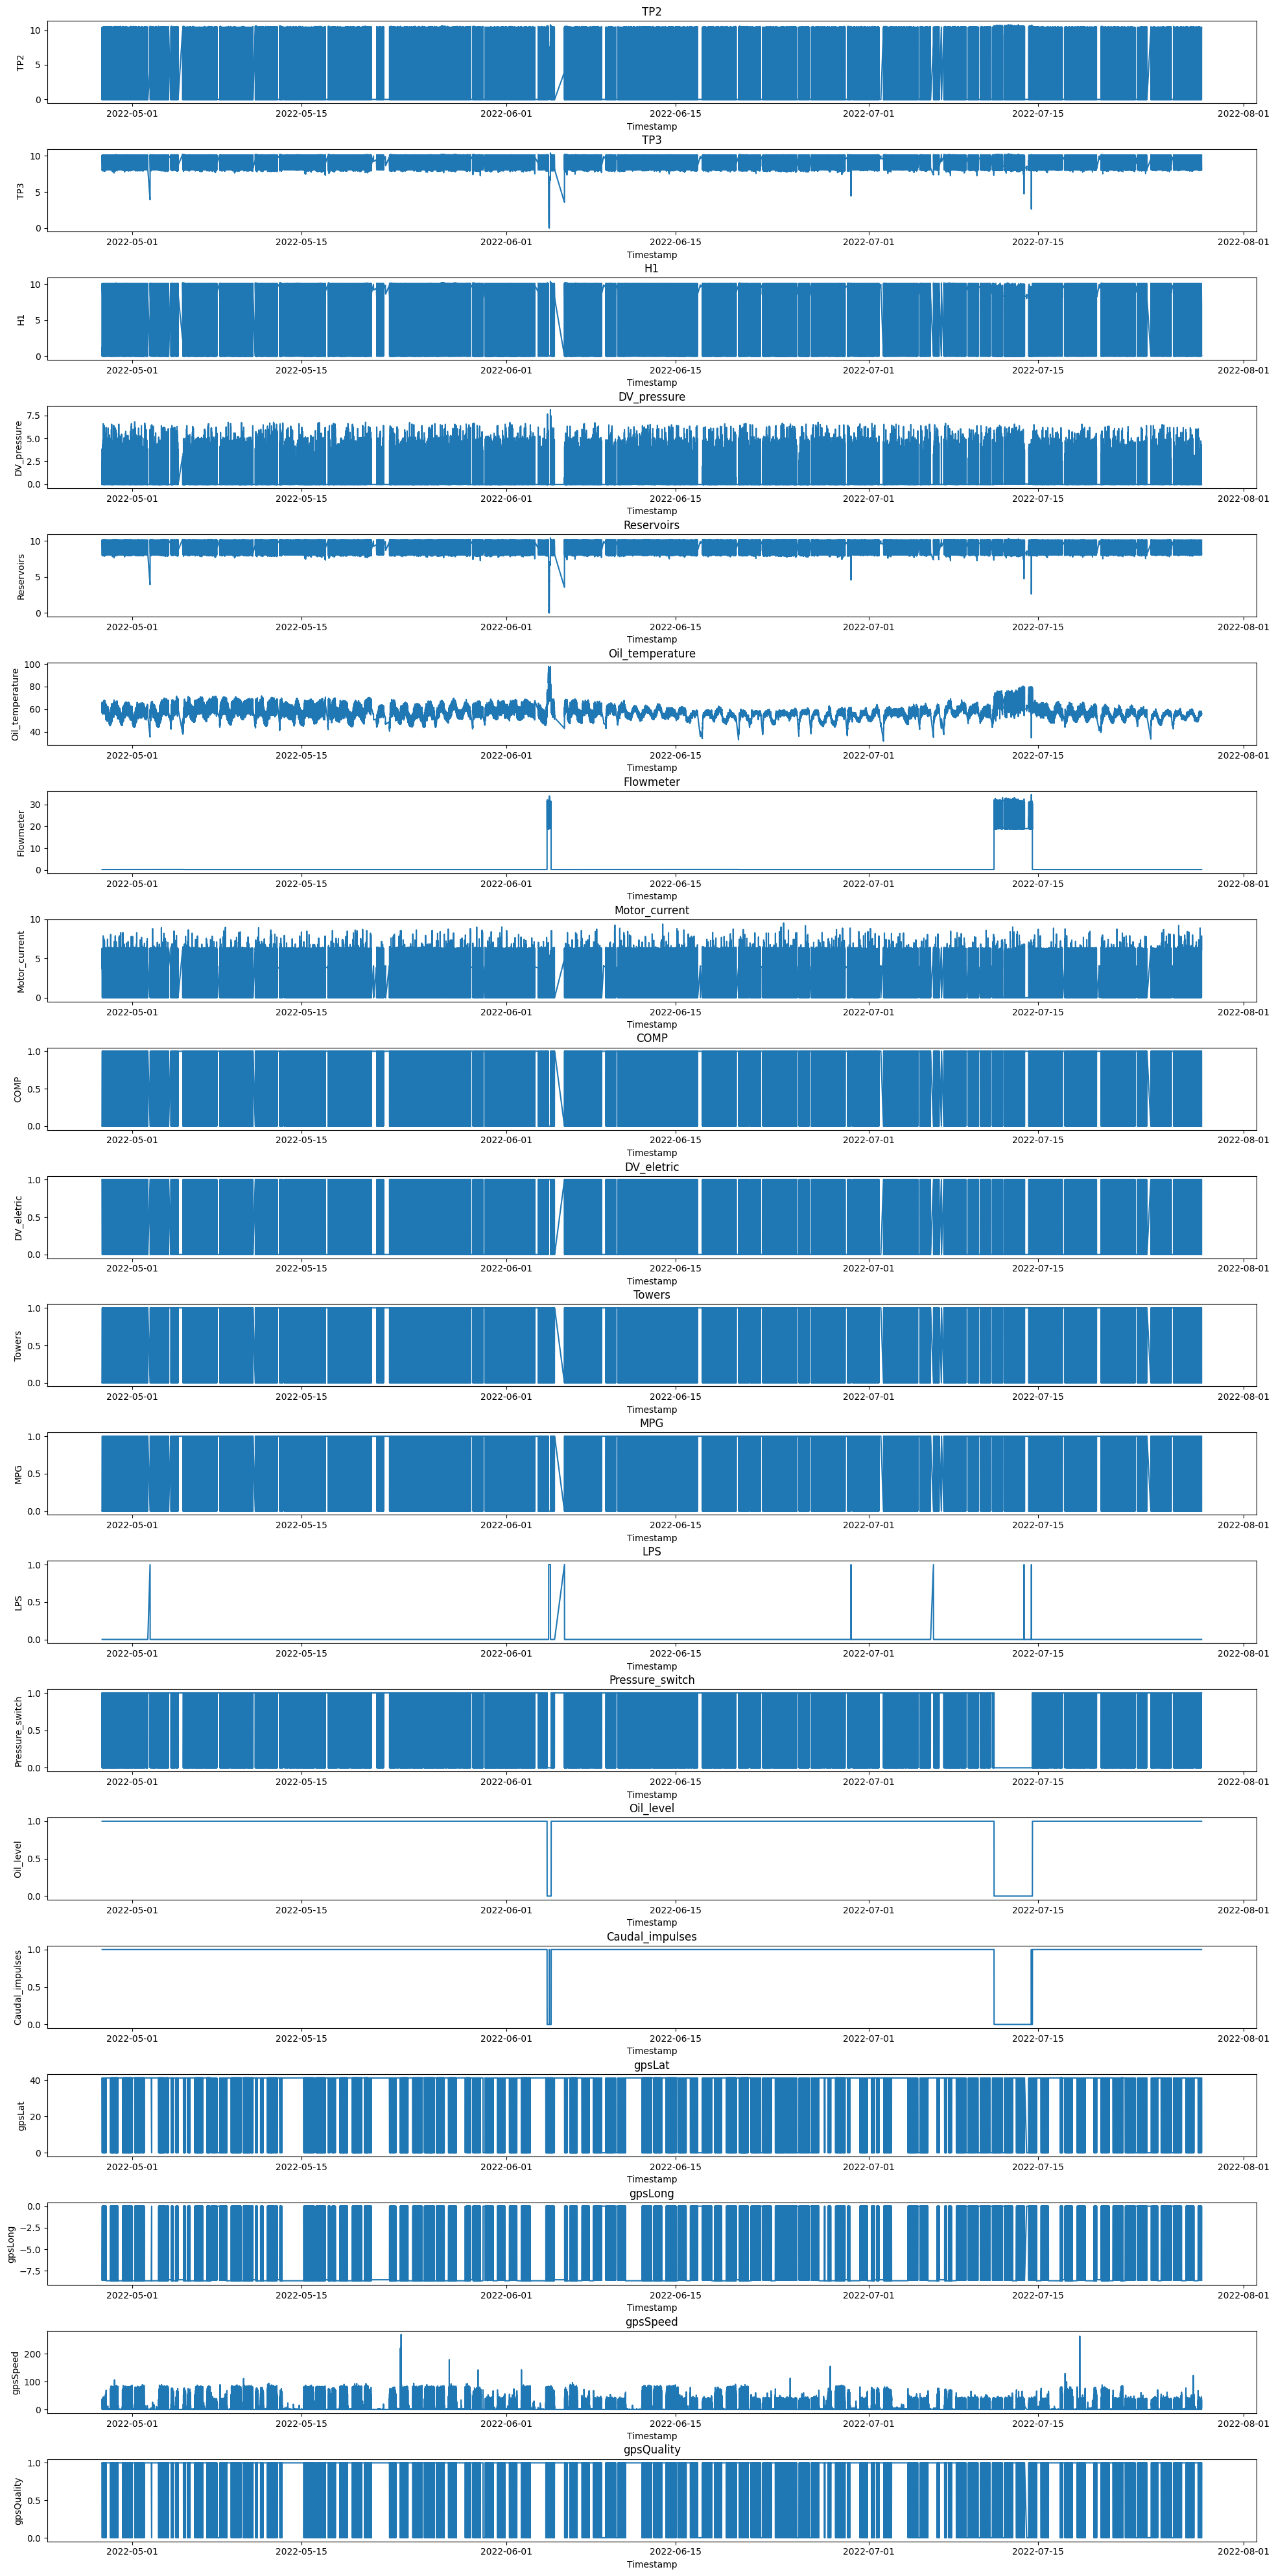

In [7]:
# Timestamps Across Features plots

def plots(df, cols: list[str]):
    num_plots = len(cols)
    fig, axs = plt.subplots(num_plots, 1, figsize=(20, 2*num_plots))
    fig.tight_layout(pad=3.0)

    for idx, col in enumerate(cols):
        axs[idx].plot(df['timestamp'], df[col])
        axs[idx].set_title(col)
        axs[idx].set_xlabel('Timestamp')
        axs[idx].set_ylabel(col)

    plt.show()

columns = df_metro.select_dtypes(exclude=['O','datetime']).columns

plots(df_metro, columns)

In [8]:
# Dropping the GPS Sensor Data

df_metro.drop(['gpsLat', 'gpsLong', 'gpsSpeed', 'gpsQuality'] , axis=1, inplace=True)

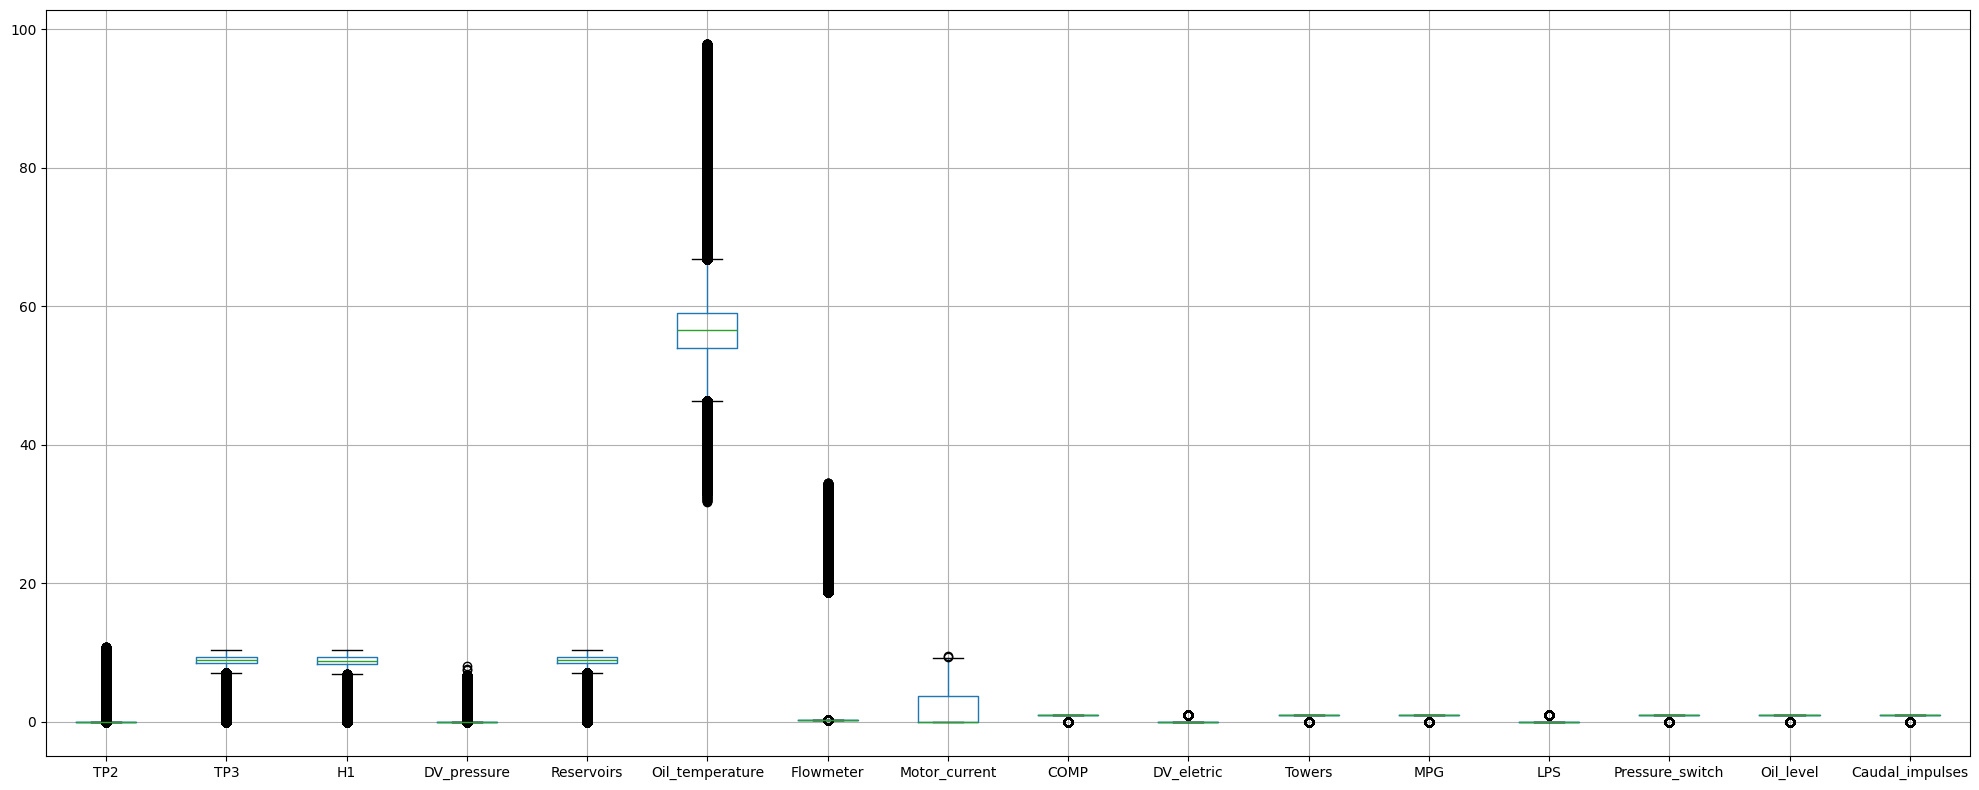

In [9]:
# Checking for the Outliers

df_metro.boxplot(figsize=(20,8))
plt.tight_layout()
plt.show()

In [10]:
# checking for missing values

df_metro.isna().sum()

timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Flowmeter          0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
dtype: int64

In [11]:
# checking for duplicate records

df_metro[df_metro.duplicated()].count()

timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Flowmeter          0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
dtype: int64

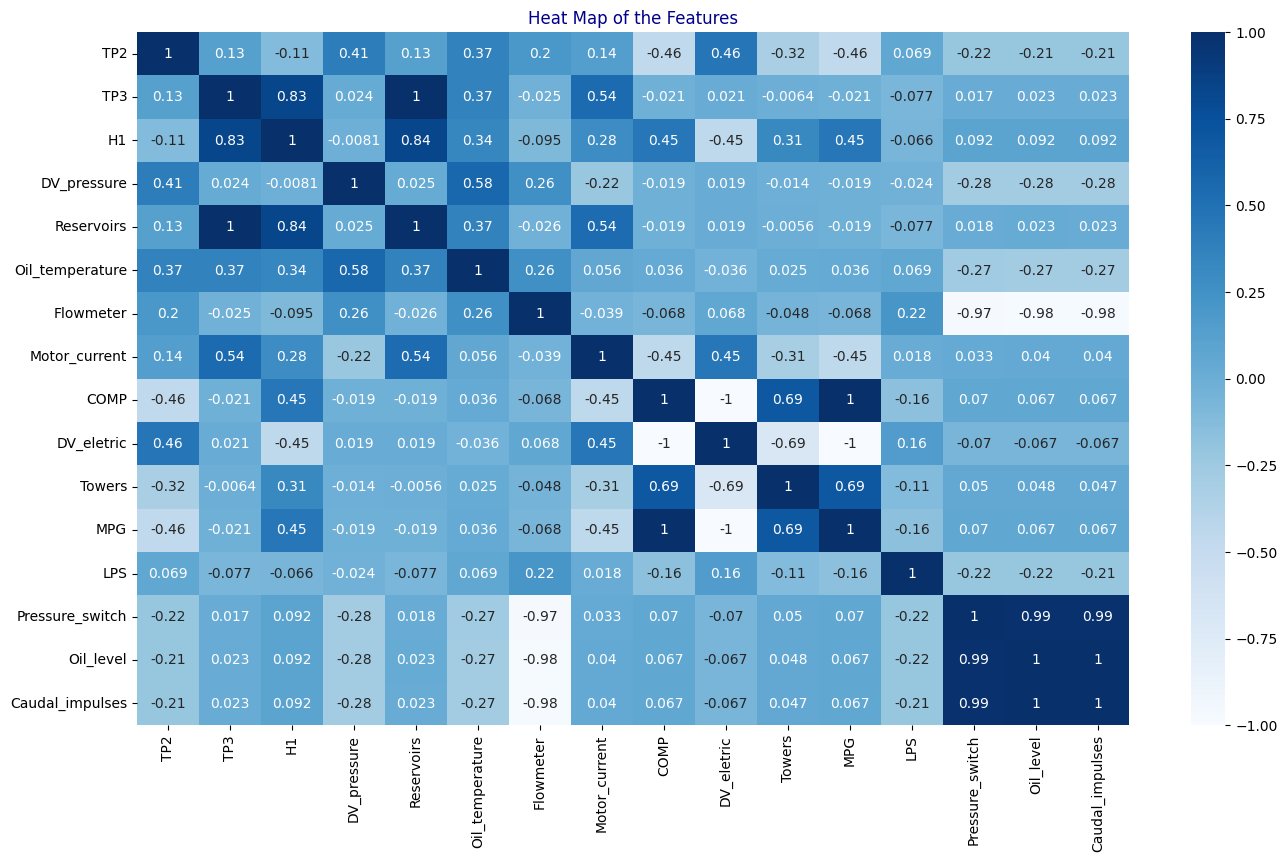

In [12]:
# Heatmap of the correlation

cols = df_metro.select_dtypes(exclude=['O','datetime'])

fig, ax = plt.subplots(figsize=(16,9))
plt.title('Heat Map of the Features', family='sans', color='darkblue', size=12)
sns.heatmap(data=cols.corr('spearman'), vmin=-1, vmax=+1, cmap='Blues', annot=True)
plt.show()

<ul>
    <h3>Observations:</h3>
    <li>TP3 was positively correlated with each other reservoirs (100%), H1 (83%).</li>
    <li>H1 was positively correlated with each other reservoirs (84%).</li>
    <li>FlowMeter was negatively correlated with each other pressure switch (-97%), oil level (-98%), and caudal impulses (-98%).</li>
    <li>COMP was positively correlated with each other MPG (100%).</li>
    <li>Pressure switch was positively correlated with each other oil level (99%) and caudal impulses (99%).</li>
    <li>Oil level was positively correlated with each other caudal impulses (100%).</li>
</ul>


In [13]:
# To avoid multicollinearity, drop redundant columns

df_metro.drop(columns=['Reservoirs', 'Flowmeter', 'COMP', 'Pressure_switch', 'Caudal_impulses'], axis=1, inplace=True)

<div style="font-size:140%">Calculate the Remaining Useful Life (RUL) using the provided dataset information:</div>
<div style="font-size:120%">Failure Information:</div>
<small>The failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.</small>

<table style="width:60%">
  <tr>
    <th>SL.No</th>
    <th>Start Time</th>
    <th>End Time</th>
    <th>Failure</th>
  </tr>
  <tr>
    <td>1</td>
    <td>2022-06-04 10:19:24.300</td>
    <td>2022-06-04 14:22:39.188</td>
    <td>Air Leak</td>
  </tr>
  <tr>
    <td>2</td>
    <td>2022-07-11 10:10:18.948</td>
    <td>2022-07-14 10:22:08.046</td>
    <td>Oil Leak</td>
  </tr>
</table>

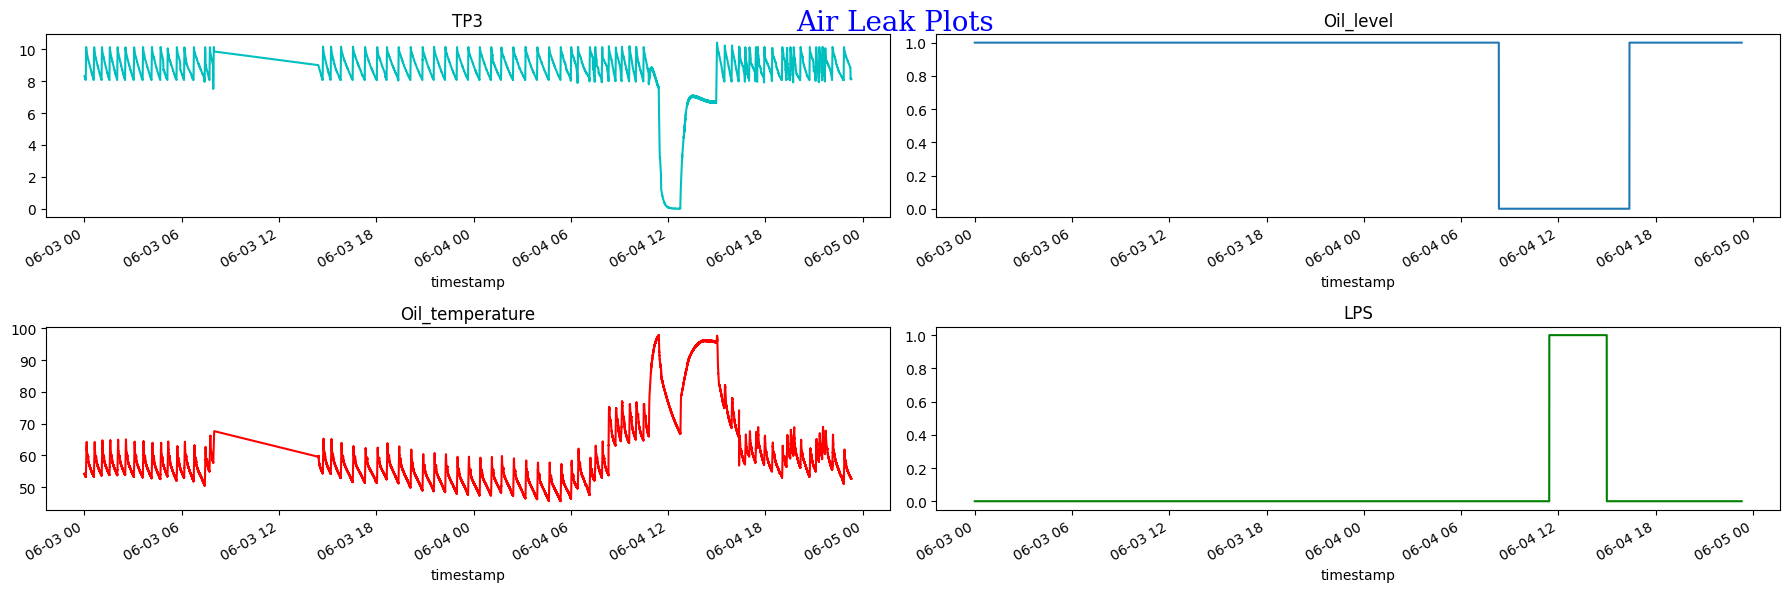

In [14]:
# Air Leak plots

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 6))
air = df_metro.set_index('timestamp')
air.loc[pd.to_datetime('2022-06-03 00:00:00.000'):pd.to_datetime('2022-06-05 09:00:00.000')]['TP3'].plot(ax=ax[0, 0],color='c')
ax[0, 0].set_title('TP3')
air.loc[pd.to_datetime('2022-06-03 00:00:00.000'):pd.to_datetime('2022-06-05 09:00:00.000')]['Oil_level'].plot(ax=ax[0, 1])
ax[0, 1].set_title('Oil_level')
air.loc[pd.to_datetime('2022-06-03 00:00:00.000'):pd.to_datetime('2022-06-05 09:00:00.000')]['Oil_temperature'].plot(ax=ax[1, 0], color='red')
ax[1, 0].set_title('Oil_temperature')
air.loc[pd.to_datetime('2022-06-03 00:00:00.000'):pd.to_datetime('2022-06-05 09:00:00.000')]['LPS'].plot(ax=ax[1, 1], color='green')
ax[1, 1].set_title('LPS')
plt.tight_layout()
plt.suptitle('Air Leak Plots',  size=20, family='serif', color='Blue')
plt.show()

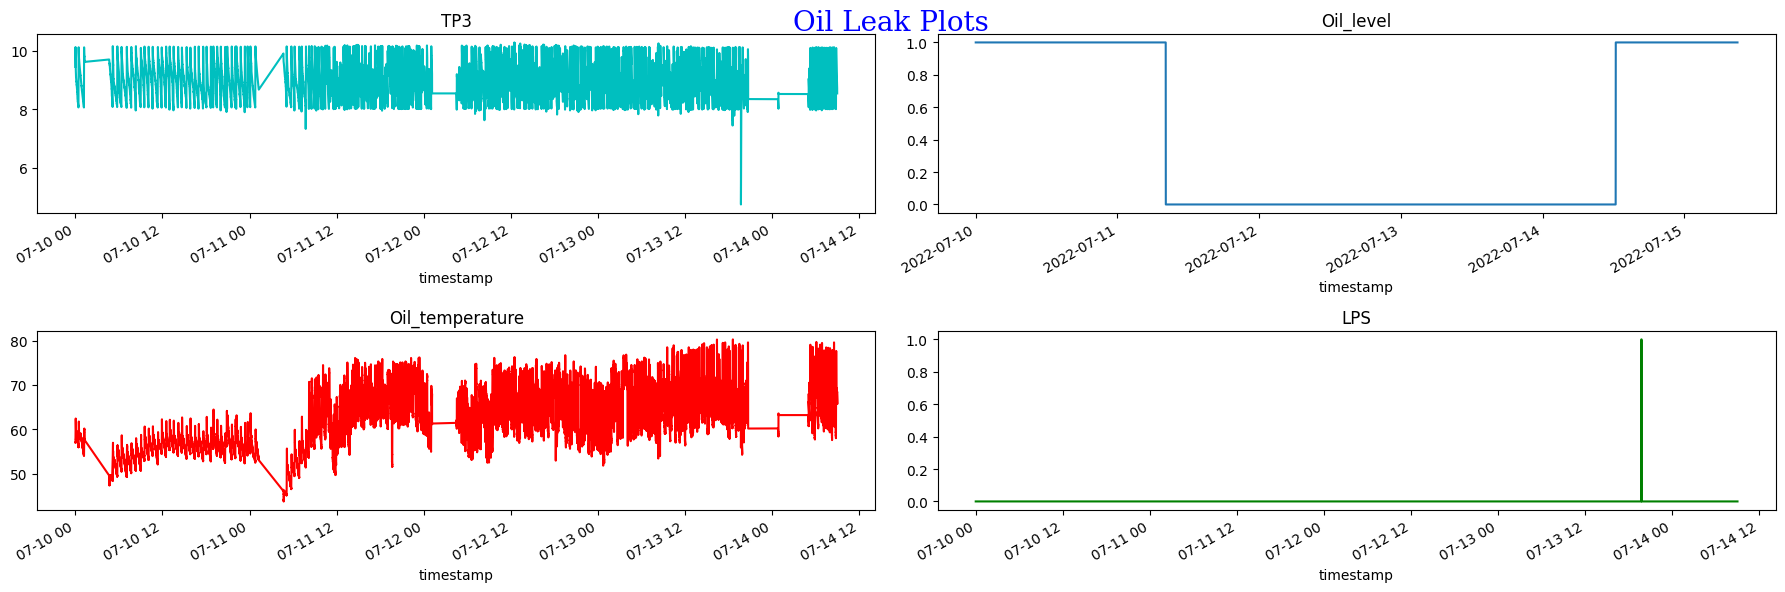

In [15]:
# Oil Leak plots

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 6))
oil = df_metro.set_index('timestamp')
oil.loc[pd.to_datetime('2022-07-10 00:00:00.000'):pd.to_datetime('2022-07-14 09:00:00.000')]['TP3'].plot(ax=ax[0, 0],color='c')
ax[0, 0].set_title('TP3')
oil.loc[pd.to_datetime('2022-07-10 00:00:00.000'):pd.to_datetime('2022-07-15 09:00:00.000')]['Oil_level'].plot(ax=ax[0, 1])
ax[0, 1].set_title('Oil_level')
oil.loc[pd.to_datetime('2022-07-10 00:00:00.000'):pd.to_datetime('2022-07-14 09:00:00.000')]['Oil_temperature'].plot(ax=ax[1, 0], color='red')
ax[1, 0].set_title('Oil_temperature')
oil.loc[pd.to_datetime('2022-07-10 00:00:00.000'):pd.to_datetime('2022-07-14 09:00:00.000')]['LPS'].plot(ax=ax[1, 1], color='green')
ax[1, 1].set_title('LPS')
plt.tight_layout()
plt.suptitle('Oil Leak Plots',  size=20, family='serif', color='Blue')
plt.show()

In [16]:
# Calculating the Reamaining useful life of engine (RUL)

failures = [
    {'failure': 'Air Leak', 'start_time': '2022-06-04 10:19:24.300', 'end_time': '2022-06-04 14:22:39.188'},
    {'failure': 'Oil Leak', 'start_time': '2022-07-11 10:10:18.948', 'end_time': '2022-07-14 10:22:08.046'}
]

for failure in failures:
    failure['start_time'] = pd.to_datetime(failure['start_time'])
    failure['end_time'] = pd.to_datetime(failure['end_time'])

def calculate_rul(row):
    for failure in failures:
        if row['timestamp'] < failure['end_time']:
            rul = (failure['end_time'] - row['timestamp']).total_seconds()
            return rul//3600
    return 0

df_metro['RUL'] = df_metro.apply(calculate_rul, axis=1)

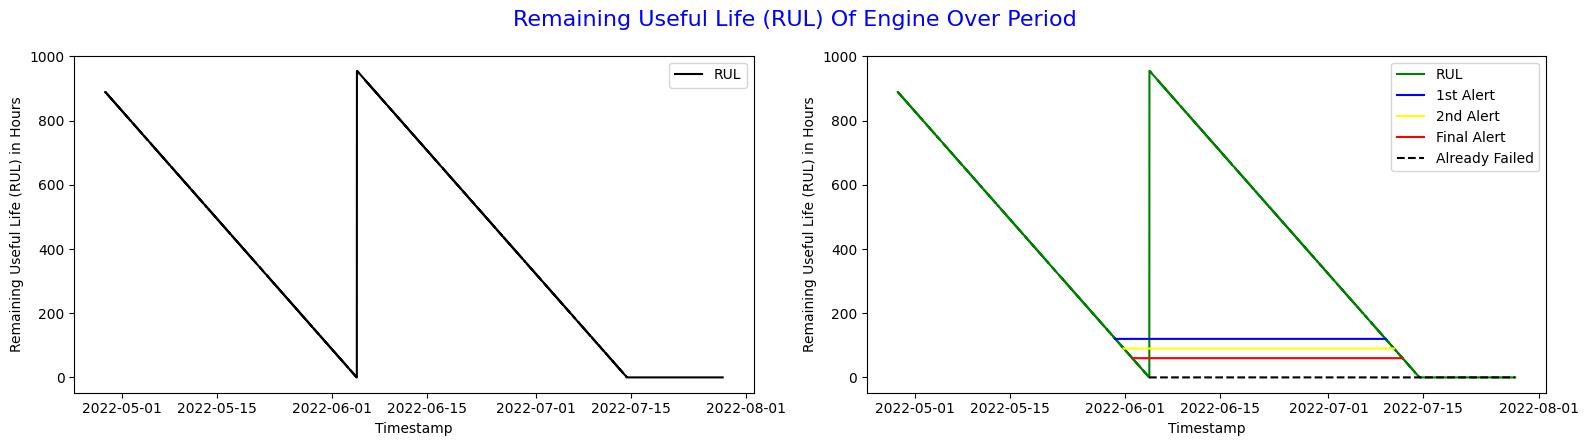

In [17]:
# General overview of the Remaining Useful Life Of Engine and alerts

plt.figure(figsize=(16,4.5))

plt.subplot(1,2,1)
plt.plot(df_metro['timestamp'], df_metro['RUL'], color='k')
plt.legend(['RUL'])
plt.xlabel('Timestamp')
plt.ylabel('Remaining Useful Life (RUL) in Hours')

plt.subplot(1,2,2)
failed_data = df_metro[df_metro['RUL'] <= 0]
warning1 = df_metro[df_metro['RUL'] == 120]     # 1st alert 
warning2 = df_metro[df_metro['RUL'] == 90]      # 2nd alert
warning3 = df_metro[df_metro['RUL'] == 60]      # 3rd alert
plt.plot(df_metro['timestamp'], df_metro['RUL'], color='green')
plt.plot(warning1['timestamp'], warning1['RUL'], linestyle='-', color='blue')
plt.plot(warning2['timestamp'], warning2['RUL'], linestyle='-', color='yellow')
plt.plot(warning3['timestamp'], warning3['RUL'], linestyle='-', color='red')
plt.plot(failed_data['timestamp'], failed_data['RUL']//60, linestyle='--', color='black')
plt.xlabel('Timestamp')
plt.ylabel('Remaining Useful Life (RUL) in Hours')
df_metro.drop('RUL', axis=1, inplace=True)
plt.suptitle('Remaining Useful Life (RUL) Of Engine Over Period', font='sans', size=16, color='b')
plt.legend(['RUL','1st Alert','2nd Alert','Final Alert','Already Failed'])
plt.tight_layout()
plt.show()

In [18]:
# Populating the Type of Failure Column

failures = [
    {'failure': 'Air Leak', 'start_time': '2022-06-04 10:19:24.300', 'end_time': '2022-06-04 14:22:39.188'},
    {'failure': 'Oil Leak', 'start_time': '2022-07-11 10:10:18.948', 'end_time': '2022-07-14 10:22:08.046'}
]
for failure in failures:
    failure['start_time'] = pd.to_datetime(failure['start_time'])
    failure['end_time'] = pd.to_datetime(failure['end_time'])

def get_failure_type(row):
    for failure in failures:
        if row['timestamp'] >= failure['start_time'] and row['timestamp'] <= failure['end_time']:
            return failure['failure']
    return 'No Failure' 

df_metro['Failure_Type'] = df_metro.apply(get_failure_type, axis=1)

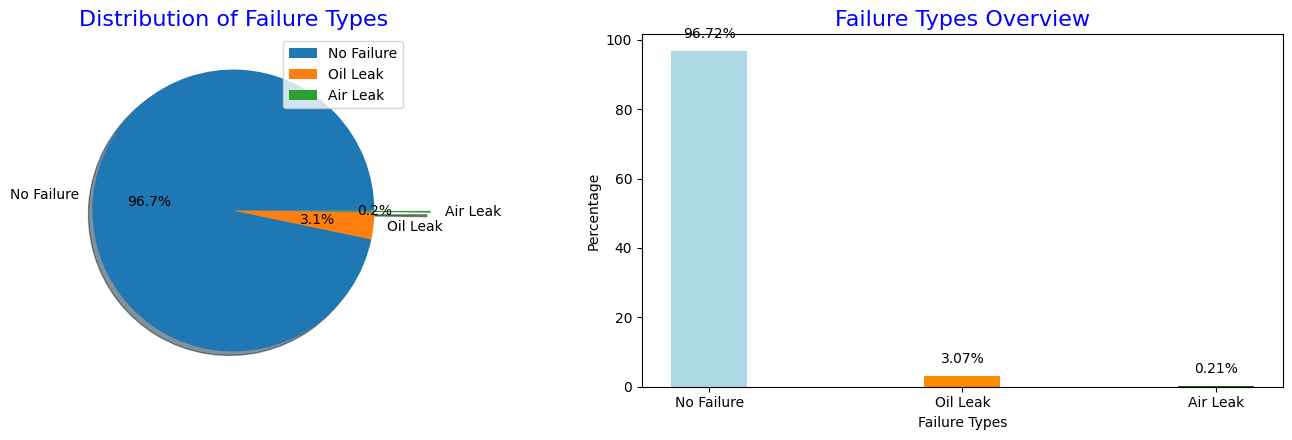

In [19]:
# Pie/Bar chart of the Failure Types

plt.figure(figsize=(14, 4.5))
plt.subplot(1, 2, 1)
plt.pie(df_metro['Failure_Type'].value_counts(), labels=['No Failure','Oil Leak','Air Leak'], explode=[0, 0, .40], shadow=True, autopct='%1.1f%%')
plt.title('Distribution of Failure Types', family='sans', size=16, color='blue')
plt.legend()

plt.subplot(1, 2, 2)
y = round(((df_metro['Failure_Type'].value_counts() / df_metro['Failure_Type'].count()) * 100), 2)
plt.bar(['No Failure','Oil Leak','Air Leak'], y, width=.3, align='center', color=['lightblue', 'darkorange', 'green'])
for i, v in enumerate(y):
    plt.text(i, v + 3, f"{v}%", ha='center', va='bottom', color='k')

plt.title('Failure Types Overview', family='sans', size=16, color='blue')
plt.xlabel('Failure Types')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()


In [20]:
# Data preprocessing steps

# y = df_metro['Failure_Type']
# X = df_metro.drop(['timestamp','Failure_Type'], axis=1)


# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

# scaler = StandardScaler()

# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [21]:
# Apply PCA transformation

# pca = PCA(n_components=3) 
# x_train_pca = pca.fit_transform(x_train)
# x_test_pca = pca.transform(x_test)

In [22]:
# Anomaly detection models 

# models = {
#     "KMeans": KMeans(n_clusters=4),
#     "IsolationForest": IsolationForest(contamination=0.05),
#     "OneClassSVM": OneClassSVM(nu=0.1)
# }

# def model_trainer(models, x_train, x_test, y_test):
#     trained_models = {}
#     predictions = {}
#     for model_name, model in models.items():
#         trained_models[model_name + '_model'] = model.fit(x_train)
#         print(f'{model_name} Training completed')
#         predictions[model_name + '_pred'] = trained_models[model_name + '_model'].predict(x_test)
#         print("Classification Report for", model_name, ":")
#         print(classification_report(y_test, predictions[model_name + '_pred']))

# model_trainer(models, x_train_pca, x_test_pca, y_test)

In [23]:
# Hyperparameter Tuning for KMeans

# param_grid = {
#     'n_clusters': [3, 4, 5],
#     'init': ['k-means++', 'random'],
#     'n_init': [10, 20, 30]
# }

# kmeans = KMeans(random_state=42)

# grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring='adjusted_rand_score')
# grid_search.fit(x_train_pca) 

# best_params = grid_search.best_params_
# print("Best parameters:", best_params)

# best_kmeans = KMeans(random_state=42, **best_params)
# best_kmeans.fit(x_train_pca)

In [24]:
# Hyperparameter Tuning for IsolationForest

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_samples': ['auto', 100, 200],
#     'contamination': [0.01, 0.02, 0.03]
# }

# isolation_forest = IsolationForest(random_state=42)

# scorer = make_scorer(f1_score, average='weighted')

# grid_search = GridSearchCV(isolation_forest, param_grid, cv=5, scoring=scorer)
# grid_search.fit(x_train_pca, y_train)

# best_params = grid_search.best_params_
# print("Best parameters:", best_params)

# best_isolation_forest = IsolationForest(random_state=42, **best_params)
# best_isolation_forest.fit(x_train_pca)

In [25]:
# Categorical column encoding for classification problem

# encoder = OneHotEncoder()
# y_train_encode = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
# y_test_encode = encoder.transform(y_test.values.reshape(-1,1)).toarray()

In [26]:
# Multi-Output Classification using RandomForest Base Classifier

# base_classifier = RandomForestClassifier()
# multi_target_classifier = MultiOutputClassifier(base_classifier, n_jobs=-1)
# multi_target_classifier.fit(x_train, y_train_encode)

In [27]:
# RandomForest classification report

# y_pred_class = multi_target_classifier.predict(x_test)

# print(classification_report(y_test_encode, y_pred_class))

In [28]:
# Prediction of the both anomaly and RandomForest models

# anomaly_predictions = trained_models["IsolationForest_model"].predict(x_test_pca)
# anomaly_predictions = trained_models["KMeans_model"].predict(x_test_pca)

# anomaly_predictions = best_kmeans.predict(x_test_pca)
# anomaly_predictions = best_isolationforest.predict(x_test_pca)


# anomaly_indices = np.where(anomaly_predictions == -1)[0]

# anomalies_data = df_metro.iloc[anomaly_indices]

# anomalies_features = anomalies_data.drop(columns=['timestamp','RUL','Failure_Type'])
# failure_predictions = multi_target_classifier.predict(anomalies_features)

In [29]:
# Anomaly Detection Combined with RandomForest Model for Generating Alerts for Predictive maintenance

# failure_type_mapping = {
#     0: "No Failure",
#     1: "Oil Leak",
#     2: "Air Leak"
# }

# lead_times = {
#     "Air Leak": timedelta(hours=2),
#     "Oil Leak": timedelta(days=2, hours=2)
# }

# current_time = datetime.now()

# processed_anomalies = set()

# for i, anomaly_index in enumerate(anomaly_indices):
#     if anomaly_index in processed_anomalies:
#         continue
    
#     anomaly_time = current_time.strftime('%Y-%m-%d %H:%M:%S')  
#     predicted_failure_type = failure_predictions[i]
#     predicted_failure_type_names = [failure_type_mapping[num] for num, val in enumerate(predicted_failure_type) if val == 1]
    
    # for failure_type in predicted_failure_type_names:
    #     lead_time = lead_times.get(failure_type)
    #     if lead_time:
    #         maintenance_time = current_time + lead_time
    #         time_remaining = maintenance_time - current_time
    #         print(f"Anomaly detected at index {anomaly_index}. Predicted failure type: {failure_type}.")
    #         print(f"Remaining time for maintenance: {time_remaining}")
    #         last_failure_info = {
    #             "Air Leak": "2022-06-04 14:22:39.188",
    #             "Oil Leak": "2022-07-14 10:22:08.046"
    #         }
    #         last_failure_end_time = datetime.strptime(last_failure_info[failure_type], "%Y-%m-%d %H:%M:%S.%f")
    #         last_failure_duration = current_time - last_failure_end_time
    #         print(f"Time since last {failure_type}: {last_failure_duration}")
    #         print()  
    
    #         processed_anomalies.add(anomaly_index)

In [30]:
# Data preprocessing steps

X = df_metro.drop(columns=['Failure_Type','timestamp']).values  
y = df_metro['Failure_Type'].values  


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# save the scaler pickle file inside the artifacts/preprocessing

directory = "artifacts/preprocessing/"
if not os.path.exists(directory):
    os.makedirs(directory)

file_path = os.path.join(directory, "scaler.pkl")

with open(file_path, 'wb') as f:
    pickle.dump(scaler, f)

In [32]:
# Autoencoder model

# input_dim = X_train.shape[1]
# encoding_dim = 64  
# num_classes = len(np.unique(y))  
# input_layer = Input(shape=(input_dim,))

# encoder = Dense(encoding_dim, activation='relu')(input_layer)
# decoder = Dense(input_dim, activation='sigmoid')(encoder)

# autoencoder = Model(inputs=input_layer, outputs=decoder)

# autoencoder.compile(optimizer='adam', loss='mse')

# autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, verbose=True)

In [33]:
# Save the autoencoder model and loss function

# models_directory = "artifacts/models/"
# loss_function_directory = "artifacts/loss_functions/"

# if not os.path.exists(models_directory):
#     os.makedirs(models_directory)
# if not os.path.exists(loss_function_directory):
#     os.makedirs(loss_function_directory)

# model_path = os.path.join(models_directory, "autoencoder_model.keras")
# autoencoder.save(model_path)

# loss_function_path = os.path.join(loss_function_directory, "mse_function.pkl")
# with open(loss_function_path, 'wb') as f:
#     pickle.dump(tf.keras.losses.mean_squared_error, f)

In [34]:
# Loading the model and loss function

# with open('artifacts/loss_functions/mse_function.pkl', 'rb') as f:
#     mse_function = pickle.load(f)

# autoencoder = tf.keras.models.load_model(filepath='artifacts/models/autoencoder_model.keras',custom_objects={'mse': mse_function})

In [35]:
# Prediction of the test data

# reconstructed_X = autoencoder.predict(X_test)
# reconstruction_errors = np.mean(np.square(X_test - reconstructed_X), axis=1)

# thresholds = {
#     "No Failure": np.percentile(reconstruction_errors[y_test == 0], 97),
#     "Air Leak": np.percentile(reconstruction_errors[y_test == 1], 97),
#     "Oil Leak": np.percentile(reconstruction_errors[y_test == 2], 97)
# }

# predicted_classes = []
# for error in reconstruction_errors:
#     if error > thresholds["Oil Leak"]:
#         predicted_classes.append("Oil Leak")
#     elif error > thresholds["Air Leak"]:
#         predicted_classes.append("Air Leak")
#     else:
#         predicted_classes.append("No Failure")

# predicted_classes = pd.Series(predicted_classes)

In [36]:
# Autoencoder model with regularization penalties and dropout was added to avoid overfitting problems

input_dim = X_train.shape[1]
encoding_dim = 64
num_classes = len(np.unique(y)) 
input_layer = Input(shape=(input_dim,))

encoder = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
encoder = Dropout(0.5)(encoder) 
decoder = Dense(input_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True,
                          validation_data=(X_test, X_test), callbacks=[early_stopping], verbose=True)

Epoch 1/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 150s 829us/step - loss: 0.9076 - val_loss: 0.8936
Epoch 2/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 133s 748us/step - loss: 0.9022 - val_loss: 0.8932
Epoch 3/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 139s 780us/step - loss: 0.9013 - val_loss: 0.8934
Epoch 4/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 147s 824us/step - loss: 0.9028 - val_loss: 0.8941
Epoch 5/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 156s 878us/step - loss: 0.9023 - val_loss: 0.8934
Epoch 6/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 155s 871us/step - loss: 0.9008 - val_loss: 0.8932
Epoch 7/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 177s 991us/step - loss: 0.9011 - val_loss: 0.8938
Epoch 8/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 158s 889us/step - loss: 0.9023 - val_loss: 0.8931
Epoch 9/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 227s 1ms/step - loss: 0.9041 - val_loss: 0.8927
Epoch 10/20
177924/177924 ━━━━━━━━━━━━━━━━━━━━ 200s 1ms/step - loss: 0.9034 - val_loss: 0.8933
Epoch 11/20
177924/177924 ━━━━━━━━━━━━━━━━━

In [37]:
# Save the autoencoder model and loss function

models_directory = "artifacts/models/"
loss_function_directory = "artifacts/loss_functions/"

if not os.path.exists(models_directory):
    os.makedirs(models_directory)
if not os.path.exists(loss_function_directory):
    os.makedirs(loss_function_directory)

model_path = os.path.join(models_directory, "best_autoencoder_model.keras")
autoencoder.save(model_path)

loss_function_path = os.path.join(loss_function_directory, "best_mse_function.pkl")
with open(loss_function_path, 'wb') as f:
    pickle.dump(tf.keras.losses.mean_squared_error, f)

In [38]:
# Loading the autoencoder model and loss function

with open('artifacts/loss_functions/best_mse_function.pkl', 'rb') as f:
    mse_function = pickle.load(f)

autoencoder = tf.keras.models.load_model(filepath='artifacts/models/best_autoencoder_model.keras',custom_objects={'mse': mse_function})

In [39]:
# Prediction of the test data

reconstructed_X = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructed_X), axis=1)

thresholds = {
    "No Failure": np.percentile(reconstruction_errors[y_test == 0], 95),
    "Air Leak": np.percentile(reconstruction_errors[y_test == 1], 97.1),
    "Oil Leak": np.percentile(reconstruction_errors[y_test == 2], 99.8)
}

predicted_classes = []
for error in reconstruction_errors:
    if error > thresholds["Oil Leak"]:
        predicted_classes.append("Oil Leak")
    elif error > thresholds["Air Leak"]:
        predicted_classes.append("Air Leak")
    else:
        predicted_classes.append("No Failure")

predicted_classes = pd.Series(predicted_classes)

44481/44481 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step


In [40]:
# Classification report and accurarcy of the model

class_mapping = {"No Failure": 1, "Air Leak": 2, "Oil Leak": 0}
actual_values_numeric = y_test
predicted_classes_numeric = predicted_classes.map(class_mapping)

accuracy = accuracy_score(actual_values_numeric, predicted_classes_numeric)
print("Accuracy:", round(accuracy*100,2),"%")

class_names = {v: k for k, v in class_mapping.items()}
print("Classification Report:")
print(classification_report(actual_values_numeric, predicted_classes_numeric, target_names=[class_names[i] for i in range(len(class_names))]))

Accuracy: 94.37 %
Classification Report:
              precision    recall  f1-score   support

    Oil Leak       0.62      0.66      0.64      2945
  No Failure       0.97      0.97      0.97   1376498
    Air Leak       0.11      0.11      0.11     43945

    accuracy                           0.94   1423388
   macro avg       0.56      0.58      0.57   1423388
weighted avg       0.94      0.94      0.94   1423388



In [41]:
# Alerting mechanism of Failures of the predicitive maintenance system based on historic data

failure_info = [
    {"start_time": "2022-06-04 10:19:24.300", "end_time": "2022-06-04 14:22:39.188", "failure": "Air Leak"},
    {"start_time": "2022-07-11 10:10:18.948", "end_time": "2022-07-14 10:22:08.046", "failure": "Oil Leak"}
]

for info in failure_info:
    info["start_time"] = datetime.strptime(info["start_time"], "%Y-%m-%d %H:%M:%S.%f")
    info["end_time"] = datetime.strptime(info["end_time"], "%Y-%m-%d %H:%M:%S.%f")

predicted_failures = np.unique([info["failure"] for info in failure_info])

remaining_times = {
    "Air Leak": [
        timedelta(hours=2),               # 2 hours before 
        timedelta(hours=1, minutes=30),   # 1.5 hours before
        timedelta(minutes=45)             # 45 minutes before
    ],
    "Oil Leak": [
        timedelta(days=2),   # 2 days before
        timedelta(days=1),   # 1 day before
        timedelta(hours=12)  # 12 hours before
    ]
}

print("Predicted Failure Information:\n","_"*60,"\n")
for failure in predicted_failures:
    if failure in remaining_times:
        times = remaining_times[failure]
        print(f"Predicted failure type: {failure}.")
        last_failure_end_time = next((info["end_time"] for info in failure_info if info["failure"] == failure), None)
        if last_failure_end_time:
            for i, time in enumerate(times):
                alert_time = last_failure_end_time - time
                print(f"Alert {i+1} time for maintenance: {alert_time}")
        else:
            print(f"No previous {failure} recorded.")
            print()
    else:
        print(f"Failure type {failure} not found in remaining times.\n")


Predicted Failure Information:
 ____________________________________________________________ 

Predicted failure type: Air Leak.
Alert 1 time for maintenance: 2022-06-04 12:22:39.188000
Alert 2 time for maintenance: 2022-06-04 12:52:39.188000
Alert 3 time for maintenance: 2022-06-04 13:37:39.188000
Predicted failure type: Oil Leak.
Alert 1 time for maintenance: 2022-07-12 10:22:08.046000
Alert 2 time for maintenance: 2022-07-13 10:22:08.046000
Alert 3 time for maintenance: 2022-07-13 22:22:08.046000


In [42]:
# Real-time alert for failure in the metro train engine

remaining_times = {
    "Air Leak": [
        timedelta(hours=2),                 # 2 hours before
        timedelta(hours=1, minutes=30),     # 1.5 hours before
        timedelta(minutes=45)               # 45 minutes before
    ],
    "Oil Leak": [
        timedelta(days=2),      # 2 days before
        timedelta(days=1),      # 1 day before
        timedelta(hours=12)     # 12 hours before
    ]
}

def display_alerts(failure_type):
    current_time = datetime.now()
    if failure_type in remaining_times:
        times = remaining_times[failure_type]
        print(f"Predicted failure type: {failure_type}.")
        for i, time in enumerate(times):
            alert_time = current_time - time 
            print(f"Alert {i+1} time for maintenance: {alert_time}")
    else:
        print(f"Failure type {failure_type} not found in remaining times.\n")


reconstructed_X = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructed_X), axis=1)
thresholds = {
    "No Failure": np.percentile(reconstruction_errors, 95),
    "Air Leak": np.percentile(reconstruction_errors, 97.1), 
    "Oil Leak": np.percentile(reconstruction_errors, 99.9) 
}


predicted_classes = []
for error in reconstruction_errors:
    if error > thresholds["Oil Leak"]:
        predicted_classes.append("Oil Leak")
    elif error > thresholds["Air Leak"]:
        predicted_classes.append("Air Leak")
    else:
        predicted_classes.append("No Failure")

predicted_classes = pd.Series(predicted_classes)


for failure_type in predicted_classes.unique():
    if failure_type != "No Failure":
        display_alerts(failure_type)
    else:
        print("No failure predicted for the given input.\n")


44481/44481 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step
No failure predicted for the given input.

Predicted failure type: Air Leak.
Alert 1 time for maintenance: 2024-03-15 17:09:37.906772
Alert 2 time for maintenance: 2024-03-15 17:39:37.906772
Alert 3 time for maintenance: 2024-03-15 18:24:37.906772
Predicted failure type: Oil Leak.
Alert 1 time for maintenance: 2024-03-13 19:09:37.906772
Alert 2 time for maintenance: 2024-03-14 19:09:37.906772
Alert 3 time for maintenance: 2024-03-15 07:09:37.906772
